<a href="https://colab.research.google.com/github/ChristopherLiew/Recession-Forecasting-US/blob/master/EDA_%26_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Things to do:
> *   Drop DEBT_HH & Update SP500 (Using paid data :( )
> *    Drop TCU_3MTHCHANGE




In [ ]:
# Load libraries
import pandas as pd
import numpy as np
!pip install plotly -U # Update Plotly for additonal tools -> Restart runtime after update
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime
import glob
import os
from datetime import datetime
from functools import reduce
from google.colab import drive 
drive.mount('/content/gdrive')

     |████████████████████████████████| 13.2MB 315kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


## Finalised Dataset
Our finalised dataset comprises of 650 observations and 12 features.

In [ ]:
# Pull dataset
rec_data = pd.read_csv("/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/final_data.csv")
rec_data

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,DEBT_HH,SP500,INDPRO,TCU,UNRATE,Is_Recession
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.000,0.000000,34.1729,0.0000,4.0,0
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.000,0.000000,34.3945,0.0000,3.8,0
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.000,0.000000,34.8652,0.0000,3.8,0
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.000,0.000000,34.9206,0.0000,3.8,0
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.000,0.000000,35.2529,0.0000,3.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2019-10-01,151524,1.83,1.65,1.61,1.53,1.71,0.228619,106.68579,75.462,3037.560059,109.0270,76.9891,3.6,0
646,2019-11-01,151758,1.55,1.54,1.57,1.64,1.81,-0.053624,106.68579,75.462,3140.979980,110.0388,77.5723,3.6,0
647,2019-12-01,151919,1.55,1.54,1.55,1.68,1.86,-0.090977,106.68579,75.462,3230.780029,109.6527,77.1697,3.6,0
648,2020-01-01,152234,1.55,1.52,1.53,1.56,1.76,0.387977,107.71144,76.450,3225.520020,109.1845,76.8754,3.5,0


#### Get all recession periods
[Thx stack overflow](https://stackoverflow.com/questions/55696209/find-start-end-index-of-bouts-of-consecutive-equal-values) :) Cumulative sum trick.

In [ ]:
v = (rec_data['Is_Recession'] != rec_data['Is_Recession'].shift()).cumsum()
u = rec_data.groupby(v)['Is_Recession'].agg(['all', 'count'])
m = u['all'] & u['count'].ge(3)

In [ ]:
recession_periods_idx = rec_data.groupby(v).apply(lambda x: (x.index[0], x.index[-1]))[m]
recession_periods = [(rec_data.iloc[i, 0], rec_data.iloc[j, 0]) for i, j in recession_periods_idx]

## Handling Missing Data
No missing data found sans the CPI hitting 0 in certain instances and our limited historical data for S&P 500 and Household Debt.



In [ ]:
rec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               650 non-null    object 
 1   PAYEMS             650 non-null    int64  
 2   FEDFUNDS           650 non-null    float64
 3   3MTB_SECONDARYMKT  650 non-null    float64
 4   GS1                650 non-null    float64
 5   GS5                650 non-null    float64
 6   GS10               650 non-null    float64
 7   CPI                650 non-null    float64
 8   DEBT_PUB           650 non-null    float64
 9   DEBT_HH            650 non-null    float64
 10  SP500              650 non-null    float64
 11  INDPRO             650 non-null    float64
 12  TCU                650 non-null    float64
 13  UNRATE             650 non-null    float64
 14  Is_Recession       650 non-null    int64  
dtypes: float64(12), int64(2), object(1)
memory usage: 76.3+ KB


## Feature Engineering
[TBD] Provide scientific/ economic/ mathematical rationale for features engineered.

### Interest rate spread: 10 year - 3 month (See Kauppi)
Detects yield curve inversions which precede major recessions such as the GFC of 2008. However, false alarms do happen as the yield curve inverted in 2019 but a recessions was not baked in until COVID-19 happened.

In [ ]:
int_rate_spread = rec_data['GS10'] - rec_data['3MTB_SECONDARYMKT']
rec_data['10Y3MTH_SPREAD'] = int_rate_spread

In [ ]:
fig = px.box(rec_data, x="Is_Recession", y="10Y3MTH_SPREAD", 
             points = 'all',
             color="Is_Recession",
             notched=True, # used notched shape
             title="Boxplot of Interest Rate Spread"
            )
fig.show()

Interest rate spread seems to dip more deeply into negative region during a recession. However, we also see a number of negative outliers with larger negative values when there is no recession (i.e. during the Expansion period). This might be due to a yield curve inversion occurring in the leading up to an actual recession.

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = '10Y3MTH_SPREAD')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

As observed, the spread always dips into negative territory preceding a recession. Even in 2019, we observe a yield curve inversion just before 2020 between the months of May till October, foreshadowing a possible recession in late 2019 to early 2020. Of which, was triggered due to COVID-19.

### Capturing momentum
#### Rolling Window (3 month)
We use a 3 month rolling window to capture condensed information on past values of a indicator variable.
##### 1) Non farm payrolls

In [ ]:
rec_data['PAYEMS_ROLMEAN3'] = rec_data['PAYEMS'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'PAYEMS_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Appears to lag the recession rather than lead the recession. May not be super useful.

##### 2) Fed Funds Rate

In [ ]:
rec_data['FEDFUNDS_ROLMEAN3'] = rec_data['FEDFUNDS'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'FEDFUNDS_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Appears to hit a peak right before the onset of a recession.

##### 3) 10 year - 3 month interest rate spread

In [ ]:
rec_data['10Y3MTH_SPREAD_ROLMEAN3'] = rec_data['10Y3MTH_SPREAD'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = '10Y3MTH_SPREAD_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Like its unadultered interest rate spread indicator, it dips below the 0 mark prior to a recession but the values are averaged out and thus less pronounced. How would a less pronounced yield curve affect predictive accuracy.

##### 4) CPI

In [ ]:
rec_data['CPI_ROLMEAN3'] = rec_data['CPI'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'CPI_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Appears to consistently be on the rise before a recession except for the 1981 recession.

##### 5) Public Debt

In [ ]:
rec_data['DEBT_PUB_ROLMEAN3'] = rec_data['DEBT_PUB'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_PUB_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

General rising trend, but could be due to exogenous factors apart from economic climate. Appears to and naturally rises during a recession, but no clear and consistent behvaiour prior to a recession.

##### 6) Household Debt

In [ ]:
rec_data['DEBT_HH_ROLMEAN3'] = rec_data['DEBT_HH'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_HH_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
# Only tracked prior to the GFC circa 2007-8
start, end = recession_periods[-1]
fig.add_vrect(x0=start, x1=end, 
              annotation_text="recession", annotation_position="top left",
              fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Too small a sample size to determine utility, but naturally rose due to households accruing bad debt (subprime mortgage crisis).

##### 7) S&P 500 Index

In [ ]:
rec_data['SP500_ROLMEAN3'] = rec_data['SP500'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'SP500_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Observably hits a peak right before a recession. However, as observed the during COVID-19 recession, the stock market was floated up by 'over-valued' tech stocks.

##### 8) Industrial Production

In [ ]:
rec_data['INDPRO_ROLMEAN3'] = rec_data['INDPRO'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'INDPRO_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Occasionally precedes the recession (E.g. the GFC and early 2000s recession). In other cases, the peak seems to come early into the recession period.

##### 9) Capacity Utilisation

In [ ]:
rec_data['TCU_ROLMEAN3'] = rec_data['TCU'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'TCU_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Occasionally precedes the recession (E.g. the GFC and early 2000s recession). In other cases, the peak seems to come early into the recession period.

##### 10) Unemployment Rate

In [ ]:
rec_data['UNRATE_ROLMEAN3'] = rec_data['UNRATE'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'UNRATE_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Unemployment trough comes before the recession, however, there may be multiple false positives, as it could hit a local minimum and recover before dropping again. However, it seems reliable.

#### Percentage Change (3 month)
Nothing more than 3 months so we do not lose too many observations.
##### 1) Non farm payrolls

In [ ]:
rec_data['PAYEMS_3MTHCHANGE'] = rec_data['PAYEMS'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'PAYEMS_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 2) Fed Funds Rate

In [ ]:
rec_data['FEDFUNDS_3MTHCHANGE'] = rec_data['FEDFUNDS'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'FEDFUNDS_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 3) Interest rate spread

In [ ]:
rec_data['10Y3MTH_SPREAD_3MTHCHANGE'] = rec_data['10Y3MTH_SPREAD'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = '10Y3MTH_SPREAD_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 4) Inflation

In [ ]:
rec_data['CPI_3MTHCHANGE'] = rec_data['CPI'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'CPI_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 5) Public debt

In [ ]:
rec_data['DEBT_PUB_3MTHCHANGE'] = rec_data['DEBT_PUB'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_PUB_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 6) Household Debt

In [ ]:
rec_data['DEBT_HH_3MTHCHANGE'] = rec_data['DEBT_HH'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_HH_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 7) S&P 500

In [ ]:
rec_data['SP500_3MTHCHANGE'] = rec_data['SP500'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'SP500_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 8) Industrial Production

In [ ]:
rec_data['INDPRO_3MTHCHANGE'] = rec_data['INDPRO'].pct_change(periods = 3)

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'INDPRO_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Occasionally dips into negative region preceding a recession and bottoms out during a recession.

##### 9) Capacity Utilisation

In [ ]:
rec_data['TCU_3MTHCHANGE'] = rec_data['TCU'].pct_change(periods = 3)

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'TCU_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Consistently dips into negative territory preceding a recession

##### 10) Unemployment Rate

In [ ]:
rec_data['UNRATE_3MTHCHANGE'] = rec_data['UNRATE'].pct_change(periods = 3)

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'UNRATE_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Erratic but trends upwards right before a recession, but may be too noisy a variable to add sufficient predictive power.

#### Removing less promising variables


*   PAYEMS_ROLMEAN3
*   10Y3MTH_SPREAD_ROLMEAN3
*   CPI_ROLMEAN3
*   DEBT_PUB_ROLMEAN3
*   DEBT_HH_ROLMEAN3
*   SP500_ROLMEAN3
*   TCU_ROLMEAN3
*   FEDFUNDS_3MTHCHANGE
*   CPI_3MTHCHANGE
*   DEBT_PUB_3MTHCHANGE
*   DEBT_HH_3MTHCHANGE
*   UNRATE_3MTHCHANGE
*   SP500_3MTHCHANGE
*   TCU_3MTHCHANGE



In [ ]:
rec_data_final = rec_data.drop(columns=['DEBT_HH',
                                        'PAYEMS_ROLMEAN3',
                                        '10Y3MTH_SPREAD_ROLMEAN3',
                                        'CPI_ROLMEAN3',
                                        'DEBT_PUB_ROLMEAN3',
                                        'DEBT_HH_ROLMEAN3',
                                        'SP500_ROLMEAN3',
                                        'TCU_ROLMEAN3',
                                        'FEDFUNDS_3MTHCHANGE',
                                        'CPI_3MTHCHANGE',
                                        'DEBT_PUB_3MTHCHANGE',
                                        'DEBT_HH_3MTHCHANGE',
                                        'UNRATE_3MTHCHANGE',
                                        'SP500_3MTHCHANGE',
                                        'TCU_3MTHCHANGE'])

In [ ]:
# Clean data of infs and missing values
rec_data_final.replace({'' : np.NaN, np.inf: np.NaN}, inplace=True)

In [ ]:
# Write data
rec_data_final.to_csv('/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/Model Data/recession_data_final_no_lags.csv', index=False)

In [ ]:
rec_data_final

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,TCU,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.000000,34.1729,0.0000,4.0,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.000000,34.3945,0.0000,3.8,0,0.18,NaN,NaN,NaN,NaN,NaN,NaN
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.000000,34.8652,0.0000,3.8,0,0.28,4.560000,34.477533,3.866667,NaN,NaN,NaN
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.000000,34.9206,0.0000,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.000000,35.2529,0.0000,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2019-10-01,151524,1.83,1.65,1.61,1.53,1.71,0.228619,106.68579,3037.560059,109.0270,76.9891,3.6,0,0.06,2.000000,109.451267,3.600000,0.004049,-2.500000,-0.000534
646,2019-11-01,151758,1.55,1.54,1.57,1.64,1.81,-0.053624,106.68579,3140.979980,110.0388,77.5723,3.6,0,0.27,1.806667,109.512767,3.566667,0.004302,-1.843750,0.001679
647,2019-12-01,151919,1.55,1.54,1.55,1.68,1.86,-0.090977,106.68579,3230.780029,109.6527,77.1697,3.6,0,0.32,1.643333,109.572833,3.600000,0.003899,-2.684211,0.001646
648,2020-01-01,152234,1.55,1.52,1.53,1.56,1.76,0.387977,107.71144,3225.520020,109.1845,76.8754,3.5,0,0.24,1.550000,109.625333,3.566667,0.004686,3.000000,0.001445


## EDA & Further Preprocessing
1. Boxplots to show distribution of values
2. Histograms to show difference in distribution between expansion vs recession
3. Autocorrelation across lags
4. Stationarity? (Do our models depend on stationarity?) - Run Dickey Fuller?
5. Pairplot of correlations and breakdown by Recession/ Expansion

In order to prevent data leakage we should only perform EDA and further preprocessing operations (E.g. Normalisation or Standardisation) on our predefined test set (i.e. our test set before recursively expanding it during cross validation)

* DROP TCU_3MTH CHANGE*

In [ ]:
# Remove DATE
rec_data_final_EDA = rec_data_final.drop(columns=['DATE'])
rec_data_final_EDA

,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,TCU,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
0,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.000000,34.1729,0.0000,4.0,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN
1,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.000000,34.3945,0.0000,3.8,0,0.18,NaN,NaN,NaN,NaN,NaN,NaN
2,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.000000,34.8652,0.0000,3.8,0,0.28,4.560000,34.477533,3.866667,NaN,NaN,NaN
3,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.000000,34.9206,0.0000,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880
4,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.000000,35.2529,0.0000,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,151524,1.83,1.65,1.61,1.53,1.71,0.228619,106.68579,3037.560059,109.0270,76.9891,3.6,0,0.06,2.000000,109.451267,3.600000,0.004049,-2.500000,-0.000534
646,151758,1.55,1.54,1.57,1.64,1.81,-0.053624,106.68579,3140.979980,110.0388,77.5723,3.6,0,0.27,1.806667,109.512767,3.566667,0.004302,-1.843750,0.001679
647,151919,1.55,1.54,1.55,1.68,1.86,-0.090977,106.68579,3230.780029,109.6527,77.1697,3.6,0,0.32,1.643333,109.572833,3.600000,0.003899,-2.684211,0.001646
648,152234,1.55,1.52,1.53,1.56,1.76,0.387977,107.71144,3225.520020,109.1845,76.8754,3.5,0,0.24,1.550000,109.625333,3.566667,0.004686,3.000000,0.001445


### Get Partial Autocorrelation of Features to determine number of autoregressive terms needed (see [here](http://people.duke.edu/~rnau/411arim3.htm) and Kauppi Autoregressive Model)

Not too sure if we need an autoregressive model. I tbh don't fully understand the difference between using PACF against BIC/AIC for lag length selection.

Can we use the individual PACF for each feature + target to determine p and then use AIC and BIC to jointly determine the lag length for the entirety of X.

### 1) Class Imbalance

In [ ]:
print("Class ratio of Recession against Expansion: %.2f" % (rec_data_final.Is_Recession.sum() / len(rec_data_final.Is_Recession)))

Class ratio of Recession against Expansion: 0.14


In [ ]:
px.histogram(rec_data_final, x = 'Is_Recession',
             title='Class frequencies (Expansions Vs. Recessions)',
             color='Is_Recession',
             opacity=0.8)

### 2) Pairplot of all features

In [ ]:
# Change all the imputed zeros (SP500, DEBT_HH & TCU) into NAs ?
# Drop infs from pct_change in TCU since X/0 = infs
# rec_data_final_clean = rec_data_final.replace([np.inf, -np.inf], np.nan) # Losing 14 observations here hmm...

In [ ]:
# WARNING: Very expensive to run; Refer to saved image or run only when certain
# pairplot = sns.pairplot(rec_data_final_clean.drop(columns=['DATE']), hue = 'Is_Recession', dropna = True)

In [ ]:
# Save the pair plot
# pairplot.savefig('/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/pairplot.png')

### 3) Overall Distribution of Values across all Features (Boxplots grouped by Recession Indicator)

In [ ]:
# Gotta figure this out
# px.box(rec_data_final.drop(columns=['DATE']).melt(), y='value', facet_col='variable').update_yaxes(matches=None)

### 4) Heatmap of All Correlated Features
Yee Hsien you might want to drop the original features here and keep the momentum ones since a Probit or Logit model would probably not play well with high collinearity.

In [ ]:
# plt.figure(figsize=(30, 30), dpi = 80)
# sns.heatmap(rec_data_final_EDA.corr(), cmap='jet', annot=True);

### 5) Partial autocorrelation for each baseline (non feature-engineered) feature

### 0) Recession Indicator (Autoregressive component [details here](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8#:~:text=ACF%20is%20an%20(c%20o,series%20with%20its%20lagged%20values%20.&text=ACF%20considers%20all%20these%20components,a%20partial%20auto%2Dcorrelation%20function.com)) ) 

We would prefer deferring to PACF here to isolate only the specific lags which have strong predictive power on our current value.

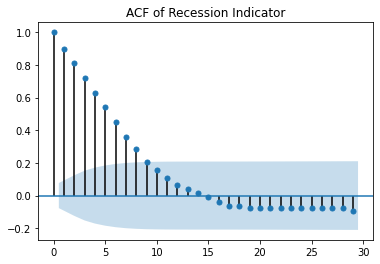

In [ ]:
# ACF for the lols
plot_acf(rec_data.Is_Recession, title = 'ACF of Recession Indicator');

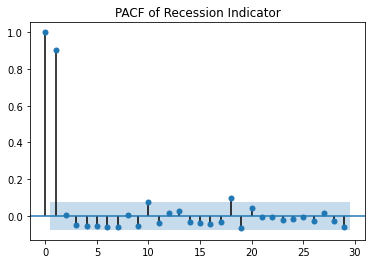

In [ ]:
# PACF for the lols
plot_pacf(rec_data.Is_Recession, title = 'PACF of Recession Indicator');

### 1) Fed Funds Rate

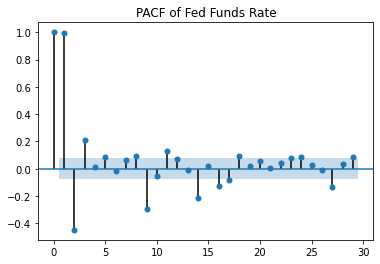

In [ ]:
# PACF 
plot_pacf(rec_data.FEDFUNDS, title = 'PACF of Fed Funds Rate');

### 2) Interest Rate Spread

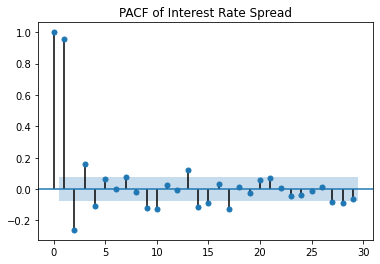

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['10Y3MTH_SPREAD']], title = 'PACF of Interest Rate Spread');

### 3) Inflation

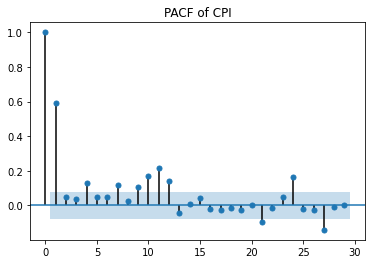

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['CPI']], title = 'PACF of CPI');

### 4) Public Debt

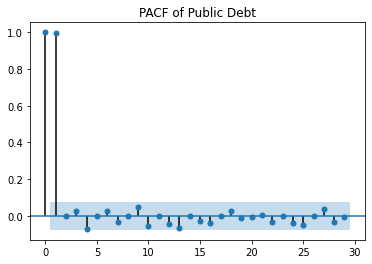

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['DEBT_PUB']], title = 'PACF of Public Debt');

### 5) Household Debt (Dropped)

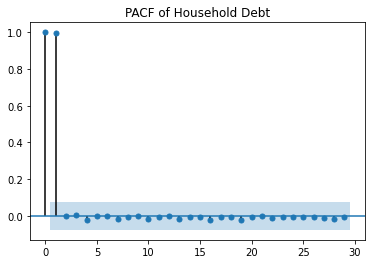

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['DEBT_HH']], title = 'PACF of Household Debt');

### 6) S&P 500

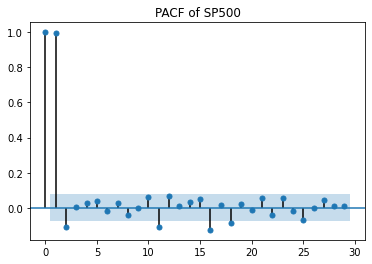

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['SP500']], title = 'PACF of SP500');

### 7) Industrial Production

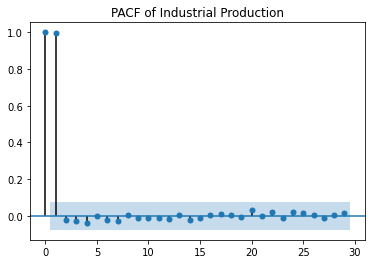

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['INDPRO']], title = 'PACF of Industrial Production');

### 8) Capacity Utilisation

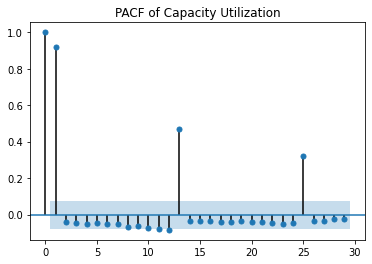

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['TCU']], title = 'PACF of Capacity Utilization');

### 9) Unemployment Rate

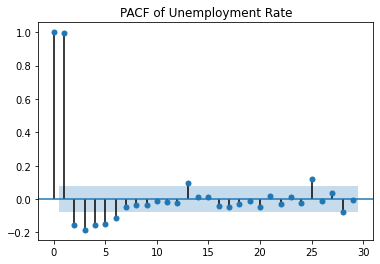

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['UNRATE']], title = 'PACF of Unemployment Rate');

For many of our variables PACF is significant up to 2nd to 4th lag, though there are some variations throughout. For instance, Unemployment Rate has a significant PACF coefficient up till about lag 25, however, we would lose to many observations by using p = 25. Thus, to create a rangle of suitable lags to empirically develop our initial lagged datasets with we will define our lagged values as 2, 6, 10 & 12, since a number of features have significant PACF coefficients at these values.

## Creating our Lagged Datasets
We will only lag our baseline features, since our transformed features already capture some 'lagged-ness' given that they are rolling means/ percentage change features.

In [ ]:
# Set directory
data_dir = "/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/Model Data/"

In [ ]:
# Generate lagged data
selected_columns = ['FEDFUNDS', '10Y3MTH_SPREAD', 'CPI', 'DEBT_PUB', 'SP500', 'INDPRO', 'TCU', 'UNRATE']
def create_lagged_data(dataset, lag_value, columns = selected_columns):
    new_data = dataset.copy()
    # For each feature, create lagged features up to the given lagged value
    for feature in columns:
        feature_data = new_data[feature]
        for lag in range(1, lag_value + 1):
            new_data[str(feature) + '_T-' + str(lag)] = feature_data.shift(lag)
    return new_data

### 1) p = 2

In [ ]:
rec_data_lag_2 = create_lagged_data(rec_data_final, 2)
rec_data_lag_2.head()

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,TCU,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE,FEDFUNDS_T-1,FEDFUNDS_T-2,10Y3MTH_SPREAD_T-1,10Y3MTH_SPREAD_T-2,CPI_T-1,CPI_T-2,DEBT_PUB_T-1,DEBT_PUB_T-2,SP500_T-1,SP500_T-2,INDPRO_T-1,INDPRO_T-2,TCU_T-1,TCU_T-2,UNRATE_T-1,UNRATE_T-2
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.0,34.1729,0.0,4.0,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.0,34.3945,0.0,3.8,0,0.18,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,0.02,NaN,0.000000,NaN,40.33999,NaN,0.0,NaN,34.1729,NaN,0.0,NaN,4.0,NaN
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.0,34.8652,0.0,3.8,0,0.28,4.560000,34.477533,3.866667,NaN,NaN,NaN,4.60,4.42,0.18,0.02,0.628931,0.000000,40.33999,40.33999,0.0,0.0,34.3945,34.1729,0.0,0.0,3.8,4.0
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.0,34.9206,0.0,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880,4.66,4.60,0.28,0.18,0.312500,0.628931,40.33999,40.33999,0.0,0.0,34.8652,34.3945,0.0,0.0,3.8,3.8
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.0,35.2529,0.0,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957,4.67,4.66,0.13,0.28,0.623053,0.312500,39.26763,40.33999,0.0,0.0,34.9206,34.8652,0.0,0.0,3.8,3.8


### 1) p = 4

In [ ]:
rec_data_lag_4 = create_lagged_data(rec_data_final, 4)
rec_data_lag_4.head()

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,TCU,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE,FEDFUNDS_T-1,FEDFUNDS_T-2,FEDFUNDS_T-3,FEDFUNDS_T-4,10Y3MTH_SPREAD_T-1,10Y3MTH_SPREAD_T-2,10Y3MTH_SPREAD_T-3,10Y3MTH_SPREAD_T-4,CPI_T-1,CPI_T-2,CPI_T-3,CPI_T-4,DEBT_PUB_T-1,DEBT_PUB_T-2,DEBT_PUB_T-3,DEBT_PUB_T-4,SP500_T-1,SP500_T-2,SP500_T-3,SP500_T-4,INDPRO_T-1,INDPRO_T-2,INDPRO_T-3,INDPRO_T-4,TCU_T-1,TCU_T-2,TCU_T-3,TCU_T-4,UNRATE_T-1,UNRATE_T-2,UNRATE_T-3,UNRATE_T-4
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.0,34.1729,0.0,4.0,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.0,34.3945,0.0,3.8,0,0.18,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,NaN,NaN,0.02,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,40.33999,NaN,NaN,NaN,0.0,NaN,NaN,NaN,34.1729,NaN,NaN,NaN,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.0,34.8652,0.0,3.8,0,0.28,4.560000,34.477533,3.866667,NaN,NaN,NaN,4.60,4.42,NaN,NaN,0.18,0.02,NaN,NaN,0.628931,0.000000,NaN,NaN,40.33999,40.33999,NaN,NaN,0.0,0.0,NaN,NaN,34.3945,34.1729,NaN,NaN,0.0,0.0,NaN,NaN,3.8,4.0,NaN,NaN
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.0,34.9206,0.0,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880,4.66,4.60,4.42,NaN,0.28,0.18,0.02,NaN,0.312500,0.628931,0.000000,NaN,40.33999,40.33999,40.33999,NaN,0.0,0.0,0.0,NaN,34.8652,34.3945,34.1729,NaN,0.0,0.0,0.0,NaN,3.8,3.8,4.0,NaN
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.0,35.2529,0.0,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957,4.67,4.66,4.60,4.42,0.13,0.28,0.18,0.02,0.623053,0.312500,0.628931,0.0,39.26763,40.33999,40.33999,40.33999,0.0,0.0,0.0,0.0,34.9206,34.8652,34.3945,34.1729,0.0,0.0,0.0,0.0,3.8,3.8,3.8,4.0


### 1) p = 10

In [ ]:
rec_data_lag_10 = create_lagged_data(rec_data_final, 10)
rec_data_lag_10.head()

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,TCU,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE,FEDFUNDS_T-1,FEDFUNDS_T-2,FEDFUNDS_T-3,FEDFUNDS_T-4,FEDFUNDS_T-5,FEDFUNDS_T-6,FEDFUNDS_T-7,FEDFUNDS_T-8,FEDFUNDS_T-9,FEDFUNDS_T-10,10Y3MTH_SPREAD_T-1,10Y3MTH_SPREAD_T-2,10Y3MTH_SPREAD_T-3,10Y3MTH_SPREAD_T-4,10Y3MTH_SPREAD_T-5,10Y3MTH_SPREAD_T-6,10Y3MTH_SPREAD_T-7,10Y3MTH_SPREAD_T-8,10Y3MTH_SPREAD_T-9,...,SP500_T-1,SP500_T-2,SP500_T-3,SP500_T-4,SP500_T-5,SP500_T-6,SP500_T-7,SP500_T-8,SP500_T-9,SP500_T-10,INDPRO_T-1,INDPRO_T-2,INDPRO_T-3,INDPRO_T-4,INDPRO_T-5,INDPRO_T-6,INDPRO_T-7,INDPRO_T-8,INDPRO_T-9,INDPRO_T-10,TCU_T-1,TCU_T-2,TCU_T-3,TCU_T-4,TCU_T-5,TCU_T-6,TCU_T-7,TCU_T-8,TCU_T-9,TCU_T-10,UNRATE_T-1,UNRATE_T-2,UNRATE_T-3,UNRATE_T-4,UNRATE_T-5,UNRATE_T-6,UNRATE_T-7,UNRATE_T-8,UNRATE_T-9,UNRATE_T-10
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.0,34.1729,0.0,4.0,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.0,34.3945,0.0,3.8,0,0.18,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.0,34.8652,0.0,3.8,0,0.28,4.560000,34.477533,3.866667,NaN,NaN,NaN,4.60,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.3945,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.0,34.9206,0.0,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880,4.66,4.60,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,0.18,0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.8652,34.3945,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.0,35.2529,0.0,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957,4.67,4.66,4.60,4.42,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.28,0.18,0.02,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,34.9206,34.8652,34.3945,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,3.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN


### 1) p = 12

In [ ]:
rec_data_lag_12 = create_lagged_data(rec_data_final, 12)
rec_data_lag_12.head()

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,TCU,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE,FEDFUNDS_T-1,FEDFUNDS_T-2,FEDFUNDS_T-3,FEDFUNDS_T-4,FEDFUNDS_T-5,FEDFUNDS_T-6,FEDFUNDS_T-7,FEDFUNDS_T-8,FEDFUNDS_T-9,FEDFUNDS_T-10,FEDFUNDS_T-11,FEDFUNDS_T-12,10Y3MTH_SPREAD_T-1,10Y3MTH_SPREAD_T-2,10Y3MTH_SPREAD_T-3,10Y3MTH_SPREAD_T-4,10Y3MTH_SPREAD_T-5,10Y3MTH_SPREAD_T-6,10Y3MTH_SPREAD_T-7,...,SP500_T-9,SP500_T-10,SP500_T-11,SP500_T-12,INDPRO_T-1,INDPRO_T-2,INDPRO_T-3,INDPRO_T-4,INDPRO_T-5,INDPRO_T-6,INDPRO_T-7,INDPRO_T-8,INDPRO_T-9,INDPRO_T-10,INDPRO_T-11,INDPRO_T-12,TCU_T-1,TCU_T-2,TCU_T-3,TCU_T-4,TCU_T-5,TCU_T-6,TCU_T-7,TCU_T-8,TCU_T-9,TCU_T-10,TCU_T-11,TCU_T-12,UNRATE_T-1,UNRATE_T-2,UNRATE_T-3,UNRATE_T-4,UNRATE_T-5,UNRATE_T-6,UNRATE_T-7,UNRATE_T-8,UNRATE_T-9,UNRATE_T-10,UNRATE_T-11,UNRATE_T-12
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.0,34.1729,0.0,4.0,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.0,34.3945,0.0,3.8,0,0.18,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.0,34.8652,0.0,3.8,0,0.28,4.560000,34.477533,3.866667,NaN,NaN,NaN,4.60,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,34.3945,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.0,34.9206,0.0,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880,4.66,4.60,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,0.18,0.02,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,34.8652,34.3945,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.0,35.2529,0.0,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957,4.67,4.66,4.60,4.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.28,0.18,0.02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,34.9206,34.8652,34.3945,34.1729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,3.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Generate Train-Test Datasets
We will use all data preceding 01-01-2000 as training data and all data following 01-01-2000 as our test data. (Elaborate on the number of recessions/ observations covered in each set)

### Compose all datasets together and remove any nulls

In [ ]:
all_dataset = [rec_data_final, rec_data_lag_2, rec_data_lag_4, rec_data_lag_10, rec_data_lag_12]
all_dataset_names =  ['rec_data_final', 'rec_data_lag_2', 'rec_data_lag_4', 'rec_data_lag_10', 'rec_data_lag_12']
all_dataset_null_removed = [i.dropna(axis=0) for i in all_dataset]

### Split into training and testing datasets and write to relevant folders

Justification for train test split

In [ ]:
def train_test_split(dataset, test_start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')):
    return {'train' : dataset[pd.to_datetime(dataset['DATE']) < test_start_date], 'test' : dataset[pd.to_datetime(dataset['DATE']) >= test_start_date]}

In [ ]:
all_dataset_split = list(map(train_test_split, all_dataset))

### Write datasets into nice and neat folders

In [ ]:
from pathlib import Path

In [ ]:
for idx, dataset in enumerate(all_dataset_split):
    dataset_path = Path(data_dir + str(all_dataset_names[idx])).mkdir(parents=True, exist_ok=True)
    # Write training data
    train_data = dataset['train']
    train_file_path = os.path.join(data_dir, all_dataset_names[idx], all_dataset_names[idx] + '_train.csv')
    train_data.to_csv(train_file_path, index=False)
    # Write test data
    test_data = dataset['test']
    test_file_path = os.path.join(data_dir, all_dataset_names[idx], all_dataset_names[idx] + '_test.csv')
    test_data.to_csv(test_file_path, index=False)